# Análisis general

En este cuaderno se explorarán las series de tiempo de los casos estimados por el IHME y se compararán con las series de los indicadores extraídos de: **GoFundMe**, **Google** y **Twitter**.

In [13]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import seaborn as sns
import matplotlib.dates as mdates

In [17]:
#tamaño 
sns.set(rc={'figure.figsize':(11, 5)})
#fondo 
sns.set_style("white")

Cargamos las series de tiempo.

In [88]:
#GoFundMe
serie_GoFundMe = pd.read_csv('../datos/series_GoFundMe.csv', parse_dates = True, index_col = 0)
serie_GoFundMe = serie_GoFundMe.loc[:,'Medical, Illness & Healing']

#IHME
serie_IHME = pd.read_csv('../datos/series_IHME.csv', parse_dates = True, index_col = 0)
serie_IHME = serie_IHME.loc[:,'Daily new estimated infections of COVID-19 (IHME, mean)']

#Twitter
serie_Twitter = pd.read_csv('../datos/series_Twitter.csv', parse_dates = True, index_col = 0).loc[:,'0']

#Google
serie_google = pd.read_csv('../datos/series_Google.csv', parse_dates = True, index_col = 0)

In [144]:
serie_google.head()

,oxigeno,GoFundMe,tratamiento covid,dexametasona,isPartial
date,,,,,
2020-05-24,15,4,2,9,False
2020-05-31,17,2,2,5,False
2020-06-07,13,6,4,9,False
2020-06-14,19,3,2,48,False
2020-06-21,12,2,3,25,False


Como la serie de tiempo de *google trends* es semanal, compararemos esta serie con un remuestreo semanal de la serie IHME:

In [145]:
# se crea una serie a partir de las estimaciones del IHME comparta los mismos índices que la series de google trens
serie_IHME_semanal = serie_IHME.loc['2020-05-24':'2021-05-09'].resample('W').mean() 

Comparamos las estimaciones del IHME con el estimador obtenido a partir de los datos obtenidos de la página de GoFundMe: 

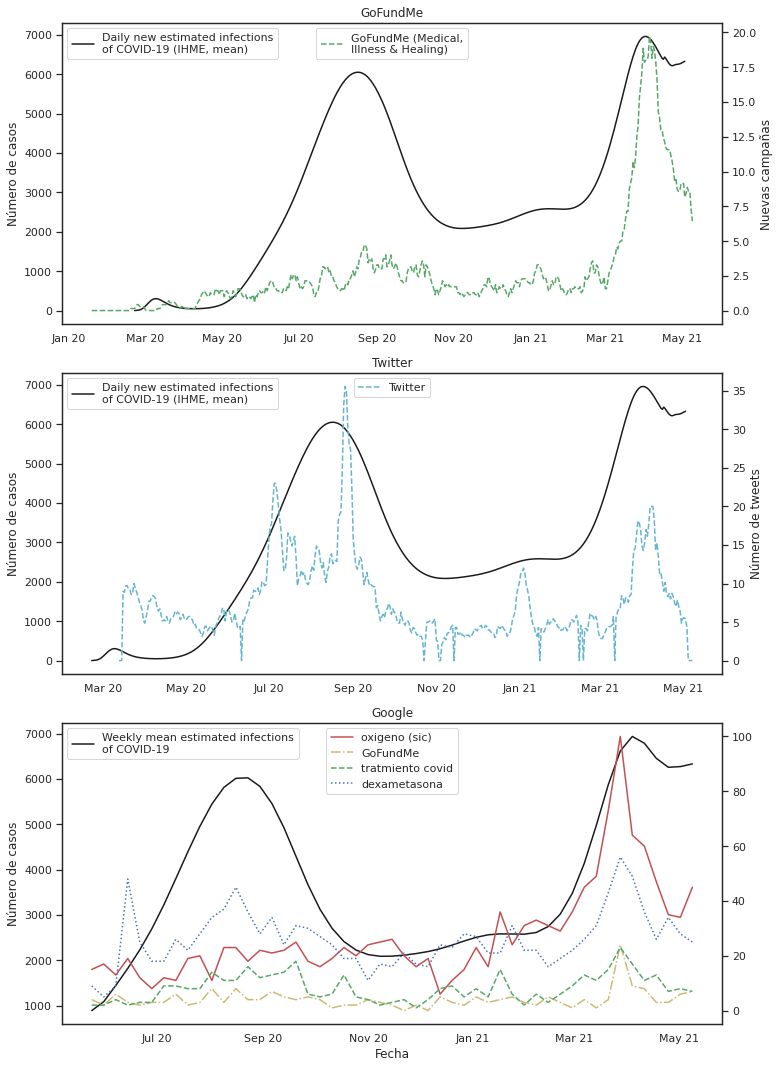

In [146]:
fig, axs = plt.subplots(3, 1, figsize = (11, 15))

# GoFundMe
ax_left = axs[0]
ax_right = ax_left.twinx() # creamos el eje gemelo a la derecha
ax_right.plot(serie_GoFundMe, label = 'GoFundMe (Medical,\nIllness & Healing)', ls = '--', color = 'g')
ax_left.plot(serie_IHME, label = 'Daily new estimated infections\nof COVID-19 (IHME, mean)', ls = '-', color = 'k')
axs[0].xaxis.set_major_formatter(mdates.DateFormatter('%b %y'))
ax_left.legend(loc = 'upper left')
ax_right.legend(loc = 'upper center' )
# nombre de los ejes y título
axs[0].set_title('GoFundMe')
ax_right.set_ylabel('Nuevas campañas')
ax_left.set_ylabel('Número de casos')

# Twitter
ax_left = axs[1]
ax_right = ax_left.twinx() # creamos el eje gemelo a la derecha
ax_right.plot(serie_Twitter, label = 'Twitter', ls = '--', color = 'c')
ax_left.plot(serie_IHME, label = 'Daily new estimated infections\nof COVID-19 (IHME, mean)', ls = '-', color = 'k')
axs[1].xaxis.set_major_formatter(mdates.DateFormatter('%b %y'))
ax_left.legend(loc = 'upper left')
ax_right.legend(loc = 'upper center' )
# nombre de los ejes
axs[1].set_title('Twitter')
ax_right.set_ylabel('Número de tweets')
ax_left.set_ylabel('Número de casos')

# google
ax_left = axs[2]
ax_right = ax_left.twinx() # creamos el eje gemelo a la derecha
ax_right.plot(serie_google.index, serie_google['oxigeno'], label = 'oxigeno (sic)', ls = '-', color = 'r')
ax_right.plot(serie_google.index, serie_google['GoFundMe'], label = 'GoFundMe', ls = '-.', color = 'y')
ax_right.plot(serie_google.index, serie_google['tratamiento covid'], label = 'tratmiento covid',ls = '--', color = 'g')
ax_right.plot(serie_google.index, serie_google['dexametasona'], label = 'dexametasona',ls = ':', color = 'b')
# usamos la serie semanal
ax_left.plot(serie_IHME_semanal, label = 'Weekly mean estimated infections\nof COVID-19', 
                                          ls = '-', color = 'k')
axs[2].xaxis.set_major_formatter(mdates.DateFormatter('%b %y'))
ax_left.legend(loc = 'upper left')
ax_right.legend(loc = 'upper center' )
# nombre de los ejes
axs[2].set_title('Google')
ax_left.set_ylabel('Número de casos')
axs[2].set_xlabel('Fecha')

plt.tight_layout()
plt.show()

### Análisis de correlación cruzada

A continuación, haremos un análisis de correlación cruzada, el cual consiste en evaluar el coeficiente de correlación de pearson considerando un *lag* o un retraso entre series. Para esto definimos la siguiente función:

In [9]:
# Time lagged cross correlation
def crosscorr(datax, datay, lag=0):
    """ Esta función calcula el coeficiente de correlación considerando un lag entre series
    """
    return datax.corr(datay.shift(lag)) #se 

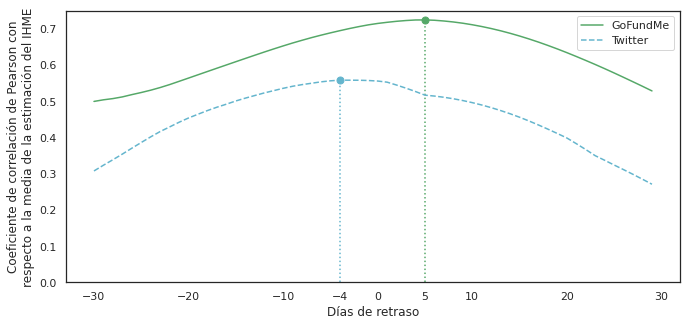

In [171]:
n = 30

lags = np.arange(-n, n, 1) 

#GoFundme
rs = np.nan_to_num([crosscorr(serie_GoFundMe, serie_IHME, lag) for lag in lags])
plt.plot(lags, rs, ls = '-', color = 'g', label = 'GoFundMe')
max_GoFundMe = lags[rs.argmax()]
# indicamos el máximo
plt.plot([max_GoFundMe, max_GoFundMe], [0, rs.max()], color = 'g', ls = ':')
plt.plot([max_GoFundMe],[rs.max()], "og", markersize = 7)

#twitter
# para comparar las series de tiempo necesitamos que los índices de ambas sean naive:
serie_Twitter.index = serie_Twitter.index.tz_localize(None) 
rs = np.nan_to_num([crosscorr(serie_Twitter, serie_IHME, lag) for lag in lags])
plt.plot(lags, rs, ls = '--', color = 'c', label = 'Twitter')
max_Twitter= lags[rs.argmax()]
# indicamos el máximo
plt.plot([max_Twitter, max_Twitter], [0, rs.max()], color = 'c', ls = ':')
plt.plot([max_Twitter],[rs.max()], "oc", markersize = 7)


plt.ylabel('Coeficiente de correlación de Pearson con\nrespecto a la media de la estimación del IHME')
plt.xlabel('Días de retraso')
plt.xticks([-30, -20, -10, max_Twitter, 0, max_GoFundMe, 10, 20, 30])
plt.ylim(0,0.75)
plt.legend()
plt.show()

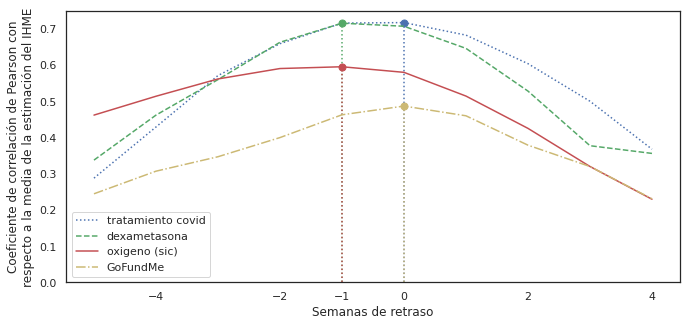

In [170]:
n = 5

lags = np.arange(-n, n, 1)

#tratamiento covid
rs = np.nan_to_num([crosscorr(serie_google['tratamiento covid'], serie_IHME_semanal, lag) for lag in lags])
plt.plot(lags, rs, label = 'tratamiento covid', ls = ':', color = 'b')
max_loc = lags[rs.argmax()]
# indicamos el máximo
plt.plot([max_loc, max_loc], [0, rs.max()], color = 'b', ls = ':')
plt.plot([max_loc],[rs.max()], "ob", markersize = 7)

#dexametasona
rs = np.nan_to_num([crosscorr(serie_google['dexametasona'], serie_IHME_semanal, lag) for lag in lags])
plt.plot(lags, rs, label = 'dexametasona', ls = '--', color = 'g')
max_loc = lags[rs.argmax()]
# indicamos el máximo
plt.plot([max_loc, max_loc], [0, rs.max()], color = 'g', ls = ':')
plt.plot([max_loc],[rs.max()], "og", markersize = 7)

#oxigeno
rs = np.nan_to_num([crosscorr(serie_google['oxigeno'], serie_IHME_semanal, lag) for lag in lags])
plt.plot(lags, rs, label = 'oxigeno (sic)', ls = '-', color = 'r')
max_loc = lags[rs.argmax()]
# indicamos el máximo
plt.plot([max_loc, max_loc], [0, rs.max()], color = 'r', ls = ':')
plt.plot([max_loc],[rs.max()], "or", markersize = 7)

#GoFundMe
rs = np.nan_to_num([crosscorr(serie_google['GoFundMe'], serie_IHME_semanal, lag) for lag in lags])
plt.plot(lags, rs, label = 'GoFundMe', ls = '-.', color = 'y')
max_loc = lags[rs.argmax()]
# indicamos el máximo
plt.plot([max_loc, max_loc], [0, rs.max()], color = 'y', ls = ':')
plt.plot([max_loc],[rs.max()], "oy", markersize = 7)



plt.ylabel('Coeficiente de correlación de Pearson con\nrespecto a la media de la estimación del IHME')
plt.xlabel('Semanas de retraso')
plt.xticks([-4, -2, -1, 0, 2, 4])
plt.ylim(0,0.75)
plt.legend()
plt.show()